--------------------------
Project: FSDS final group work

Group: CheerUp

Tentative title: VACATION HOMES OR CRIME MAGNETS

Due Date: December 19, 2023.

Insights: Aibnb density is connected to higher incidents of (person/property) crime, citing various literatures from cities around the world

Policy recommendation: TBD. Some ideas (NEED LITERATURE TO BACKUP)

If there are relationships

1. Reactive: Increase police presence in areas with high Airbnb density
2. Proactive: Limit Airbnb density in areas with high crime rates of a certain type
3. Collaborative: Airbnb to share data with local police departments to help them identify areas with high Airbnb density
4. Punitive: Airbnb to pay a fine for every crime incident that occurs in areas with high Airbnb density
5. Preventive: Airbnb to pay for additional security cameras in areas with high Airbnb density 

If not: Other cities this but London doesn't see the same issue. Should look at improving crime by improving other aspects...

--------------------------

### Data loading and cleaning (if necessary)



Task 0a: Set up libraries and function

In [29]:
# Load all libraries
import os
from requests import get
from urllib.parse import urlparse
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
# Function to download files from remote
def cache_data(src:str, dest:str) -> str:
    """
    Create a folder to store file from URL.
    If folder doesn't already exists, then create one, before writing the file.

    src : URL
    dest : location on local drive
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) #Destination filename as path
    
    if not os.path.isfile(dfn):        
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)            
        print("\tDone downloading...")
    else:
        print(f"Found {dfn} locally!")
    return dfn

def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

In [5]:
# Define paths
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path
spath_db = 'https://www.dropbox.com/scl/fi/' # source path for dropbox
host = 'http://orca.casa.ucl.ac.uk'
path = '~jreades/data'

In [6]:
# Read in airbnb, crime, and lsoa stats files. https://www.dropbox.com/home/casa/casa_fsds_cheers. 
# Some files have been cleaned, cropped, turned into gdf and hosted on dropbox to save time later on. See cleandata.ipynb in the Github repo for more details on how these files were created.
# # [PATIENCE] Takes about 4 minutes to download and read in the data

# Crime data filtered for September 2023, within Greater London
crime = gpd.read_file(cache_data(spath_db + 'ewc9skqcfr930whzcjadd/crime.gpkg?rlkey=xjve2mmmmt5h3allsa2zpabya&dl=1', ddir),driver='gpkg',low_memory=False)

# Airbnb listing data scraped on September 2023, filtered within Greater London
listings = gpd.read_parquet( cache_data(f'{host}/{path}/2023-09-06-listings.geoparquet', ddir))
listings = listings.to_crs(epsg=27700)

# LSOA (London) data concatenated from multiple datasets from London Datastore,
lsoa_stat = pd.read_csv(cache_data(spath_db + '8zc0g09rlf1yhj6j7yn6n/lsoa_full.csv?rlkey=yopr4hv017rr3iv4e2zus0ifz&dl=1', ddir), low_memory=False)

print('Done.')

Found data/geo/crime.gpkg locally!
data/geo/2023-09-06-listings.geoparquet not found, downloading!
	Done downloading...
Found data/geo/lsoa_full.csv locally!


In [7]:
# Read in shapefiles (2 mins)
water = gpd.read_file(cache_data(spath+'Water.gpkg?raw=true', ddir))
green = gpd.read_file(cache_data(spath+'Greenspace.gpkg?raw=true', ddir))
boros = gpd.read_file(cache_data(spath+'Boroughs.gpkg?raw=true', ddir))
lsoa = gpd.read_file(cache_data(spath_db+'u367zlorie8vuluugy2fr/lsoa_london.gpkg?rlkey=rc7rdnlfdmzfgy5q7ujz9pnwj&dl=1', ddir))
print('Done.')

Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/lsoa_london.gpkg locally!
Done.


In [8]:
#Check CRS for all geo dataframes
print(water.crs, green.crs, boros.crs, lsoa.crs, crime.crs, listings.crs)
# All dataframes are in EPSG:27700

EPSG:27700 EPSG:27700 EPSG:27700 EPSG:27700 EPSG:27700 EPSG:27700


<Axes: >

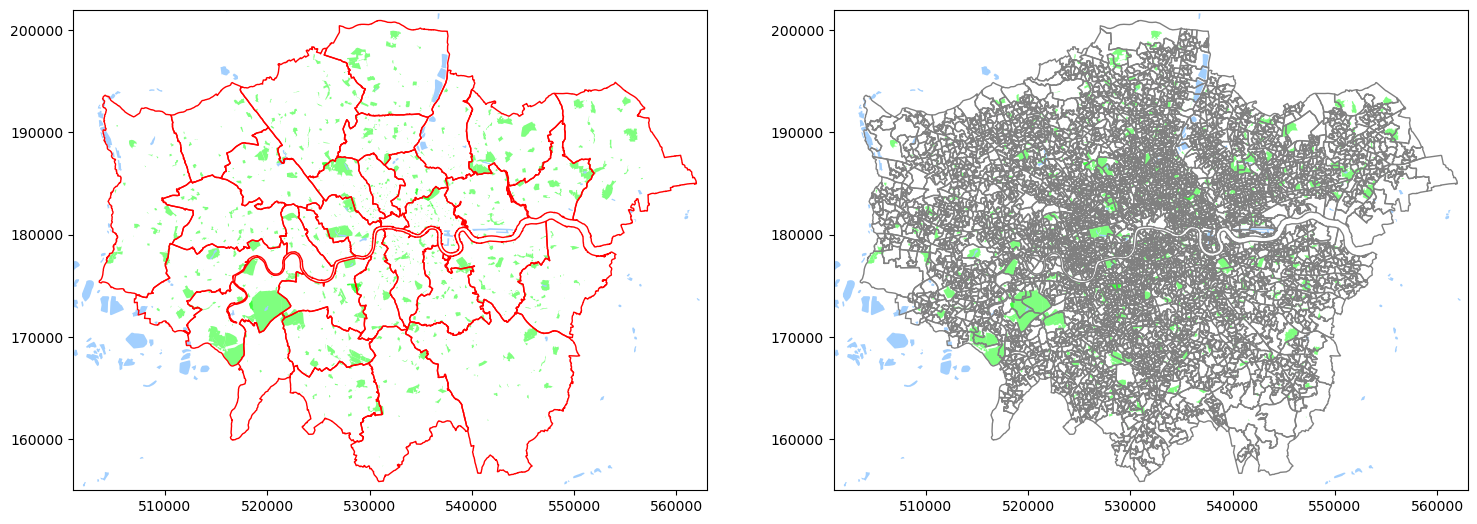

In [12]:
# Plot London map to confirm geometries are correct
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,24))

for ax in (ax1,ax2):
    green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax)
    water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    
boros.plot(edgecolor='red', facecolor='None',ax=ax1)
lsoa.plot(edgecolor='grey', facecolor='None',ax=ax2)

Text(0.5, 1.0, 'Crimes in London, Sep 2023, Metropolitan Police')

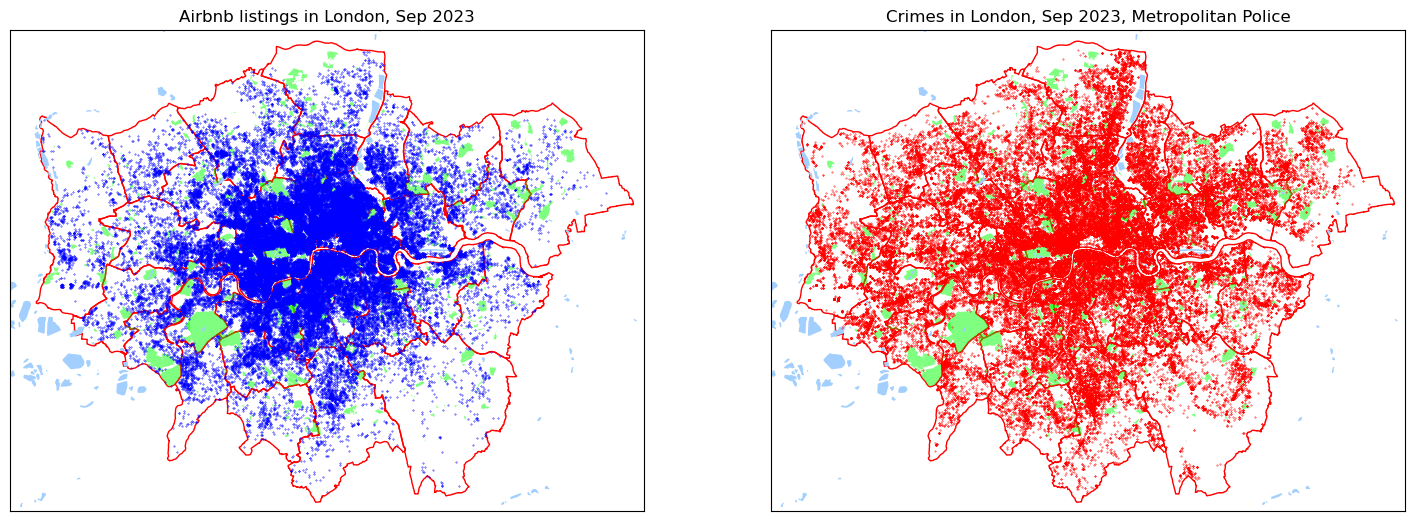

In [13]:
# Plot airbnb listings and crime incidents
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,24))

# Set the x and y limits
for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    boros.plot(edgecolor='red', facecolor='None',ax=ax)
    green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax)
    water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax)

listings.plot(ax=ax1, markersize=0.1,facecolor='blue')  
ax1.set_title('Airbnb listings in London, Sep 2023')

crime.plot(ax=ax2, markersize=0.1,facecolor='red')
ax2.set_title('Crimes in London, Sep 2023, Metropolitan Police')

In [21]:
crime.tail()

Unnamed: 0                                           Crime ID    Month  \
94954     3305419  e428fac4484cdbc20c86bf044f61ba05942d1846ada823...  2023-09   
94955     3305420  05c84401ec7d2129496a921746308384fe927f2232032a...  2023-09   
94956     3305421  dd42dcf68782f8aa553c15cac4f2ea7c13536a8b732852...  2023-09   
94957     3305422  9f2606828fc8e67fe813a95865c2bd69c7464878dfa7ce...  2023-09   
94958     3305423  db15663fb2259a3de5bb2d5147ee8b524b84bade3d76df...  2023-09   

                       Reported by                 Falls within  Longitude  \
94954  Metropolitan Police Service  Metropolitan Police Service  -0.136234   
94955  Metropolitan Police Service  Metropolitan Police Service  -0.137230   
94956  Metropolitan Police Service  Metropolitan Police Service  -0.136284   
94957  Metropolitan Police Service  Metropolitan Police Service  -0.136234   
94958  Metropolitan Police Service  Metropolitan Police Service  -0.133480   

        Latitude                            Location  LSOA code  \
94954  51.487435        On or near Chichester Street  E01035722   
94955  51.486309             On or near Parking Area  E01035722   
94956  51.485152           On or near Petrol Station  E01035722   
94957  51.487435        On or near Chichester Street  E01035722   
94958  51.486807  On or near St George'S Square Mews  E01035722   

              LSOA name                    Crime type  \
94954  Westminster 024G                  Public order   
94955  Westminster 024G         Theft from the person   
94956  Westminster 024G                 Vehicle crime   
94957  Westminster 024G  Violence and sexual offences   
94958  Westminster 024G  Violence and sexual offences   

                               Last outcome category  Context  \
94954                            Under investigation      NaN   
94955  Investigation complete; no suspect identified      NaN   
94956  Investigation complete; no suspect identified      NaN   
94957  Investigation complete; no suspect identified      NaN   
94958  Investigation complete; no suspect identified      NaN   

                            geometry Tourism-relevance            Category  
94954  POINT (529498.284 178144.827)          Relevant  Public Order crime  
94955  POINT (529432.323 178017.855)          Relevant      Property crime  
94956  POINT (529501.275 177890.866)     Less relevant      Property crime  
94957  POINT (529498.284 178144.827)     Less relevant       Violent crime  
94958  POINT (529691.259 178079.863)     Less relevant       Violent crime

In [23]:
# Clean crime data: outliers, and missing values, split into 2 types by severity
crime_property = ['Burglary', 'Criminal damage and arson',  'Theft from the person', 'Vehicle crime', 'Shoplifting', 'Bicycle theft']
crime_violent = ['Robbery', 'Violence and sexual offences']  
crime_publicorder = ['Anti-social behaviour', 'Public order','Drugs','Possession of weapons']
# Need rationalization when writing the report

# Omit rows with Other Crime and Other Theft
crime = crime[~crime['Crime type'].isin(['Other theft','Other crime'])]
# Create a new column for crime type
crime['Category'] = np.where(crime['Crime type'].isin(crime_property), 'Property crime',
                             np.where(crime['Crime type'].isin(crime_violent), 'Violent crime','Public Order crime'))
crime.tail()

Unnamed: 0                                           Crime ID    Month  \
94954     3305419  e428fac4484cdbc20c86bf044f61ba05942d1846ada823...  2023-09   
94955     3305420  05c84401ec7d2129496a921746308384fe927f2232032a...  2023-09   
94956     3305421  dd42dcf68782f8aa553c15cac4f2ea7c13536a8b732852...  2023-09   
94957     3305422  9f2606828fc8e67fe813a95865c2bd69c7464878dfa7ce...  2023-09   
94958     3305423  db15663fb2259a3de5bb2d5147ee8b524b84bade3d76df...  2023-09   

                       Reported by                 Falls within  Longitude  \
94954  Metropolitan Police Service  Metropolitan Police Service  -0.136234   
94955  Metropolitan Police Service  Metropolitan Police Service  -0.137230   
94956  Metropolitan Police Service  Metropolitan Police Service  -0.136284   
94957  Metropolitan Police Service  Metropolitan Police Service  -0.136234   
94958  Metropolitan Police Service  Metropolitan Police Service  -0.133480   

        Latitude                            Location  LSOA code  \
94954  51.487435        On or near Chichester Street  E01035722   
94955  51.486309             On or near Parking Area  E01035722   
94956  51.485152           On or near Petrol Station  E01035722   
94957  51.487435        On or near Chichester Street  E01035722   
94958  51.486807  On or near St George'S Square Mews  E01035722   

              LSOA name                    Crime type  \
94954  Westminster 024G                  Public order   
94955  Westminster 024G         Theft from the person   
94956  Westminster 024G                 Vehicle crime   
94957  Westminster 024G  Violence and sexual offences   
94958  Westminster 024G  Violence and sexual offences   

                               Last outcome category  Context  \
94954                            Under investigation      NaN   
94955  Investigation complete; no suspect identified      NaN   
94956  Investigation complete; no suspect identified      NaN   
94957  Investigation complete; no suspect identified      NaN   
94958  Investigation complete; no suspect identified      NaN   

                            geometry            Category  
94954  POINT (529498.284 178144.827)  Public Order crime  
94955  POINT (529432.323 178017.855)      Property crime  
94956  POINT (529501.275 177890.866)      Property crime  
94957  POINT (529498.284 178144.827)       Violent crime  
94958  POINT (529691.259 178079.863)       Violent crime

<Axes: >

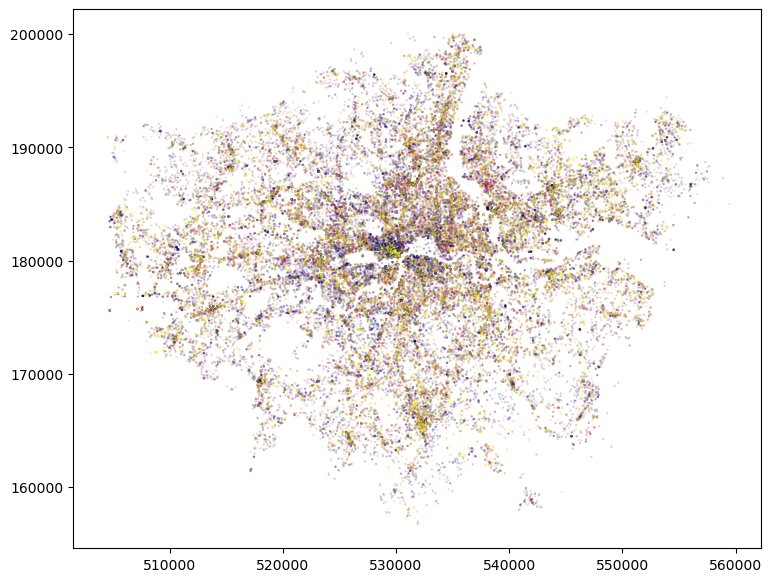

In [26]:
crime.plot(column='Category', cmap='plasma', markersize=.5, alpha=0.15, figsize=(10,7))

['Private room', 'Entire home/apt', 'Hotel room', 'Shared room']
Categories (4, object): ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']


<Axes: >

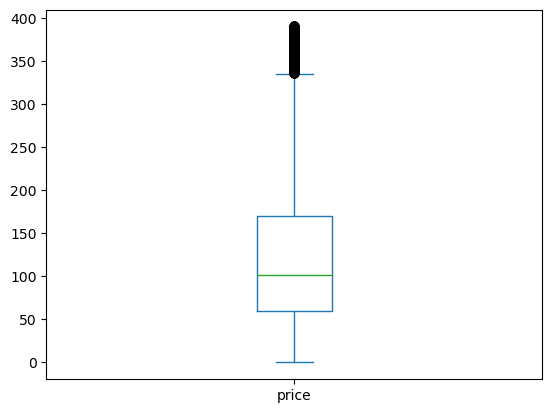

In [15]:
# Clean listings data: outliers, and missing values, split into 3 types by property type
# Omit rows with Hotel room
listings = listings[~listings['room_type'].isin(['Hotel room'])]

# Transform price to float
if listings.price.dtype == 'O':
    listings.price = listings.price.str.replace('$','').str.replace(',','').astype(float).round(2)

# Trim outliers in terms of price based on interquartile range, because they are most likely they are not real listings
q1 = listings.price.quantile(0.25)
q3 = listings.price.quantile(0.75)
iqr = q3 - q1
listings = listings[(listings.price >= q1 - 1.5*iqr) & (listings.price <= q3 + 1.5*iqr)]
listings.price.plot.box()

In [18]:
lsoa.head()

OBJECTID   LSOA21CD                   LSOA21NM  \
0         1  E01000001        City of London 001A   
1         2  E01000002        City of London 001B   
2         3  E01000003        City of London 001C   
3         4  E01000005        City of London 001E   
4         5  E01000006  Barking and Dagenham 016A   

                               GlobalID  \
0  f1865556-4e62-48e3-a025-d93a40f15e46   
1  83e78aad-ee05-44a5-a8d3-077de6ed4053   
2  69c457df-229e-4446-9577-95ac1c9be694   
3  d537d59f-237a-45ed-a514-b0ab2a93e510   
4  8d0081fe-69e2-48ac-aaf9-fd270d60e339   

                                            geometry  
0  POLYGON ((532105.312 182010.574, 532162.491 18...  
1  POLYGON ((532634.497 181926.016, 532619.141 18...  
2  POLYGON ((532135.138 182198.131, 532158.250 18...  
3  POLYGON ((533808.018 180767.774, 533649.037 18...  
4  POLYGON ((545122.049 184314.931, 545271.849 18...

### Descriptive statistics (Question #6 - 18 points)

*Objective:* 
Show the clustering of airbnb (by type), and crime incidents (by type). Show possible correlations between airbnb density and crime incidents
Approach: 

1. Split airbnb listing by 3 types (entire house/private room/shared room), and crime by 2 types (person vs property)
2. Plot out all the airbnb listings.
     - Heat map (KDE for each)
     - Descriptive statistics for each (LSOA min, max, mean, median)
3. Plot all the crime incidents, split by .
    - Heat map (KDE for each)
    - Descriptive statistics for each (LSOA min, max, mean, median)
4. Visual observation based on the heatmaps above where airbnb listings and crimes seem to overlap
5. Run correlations
-------------------------------------------------------------------------------

Task 1: Produce heat map for each type of airbnb listings against crime

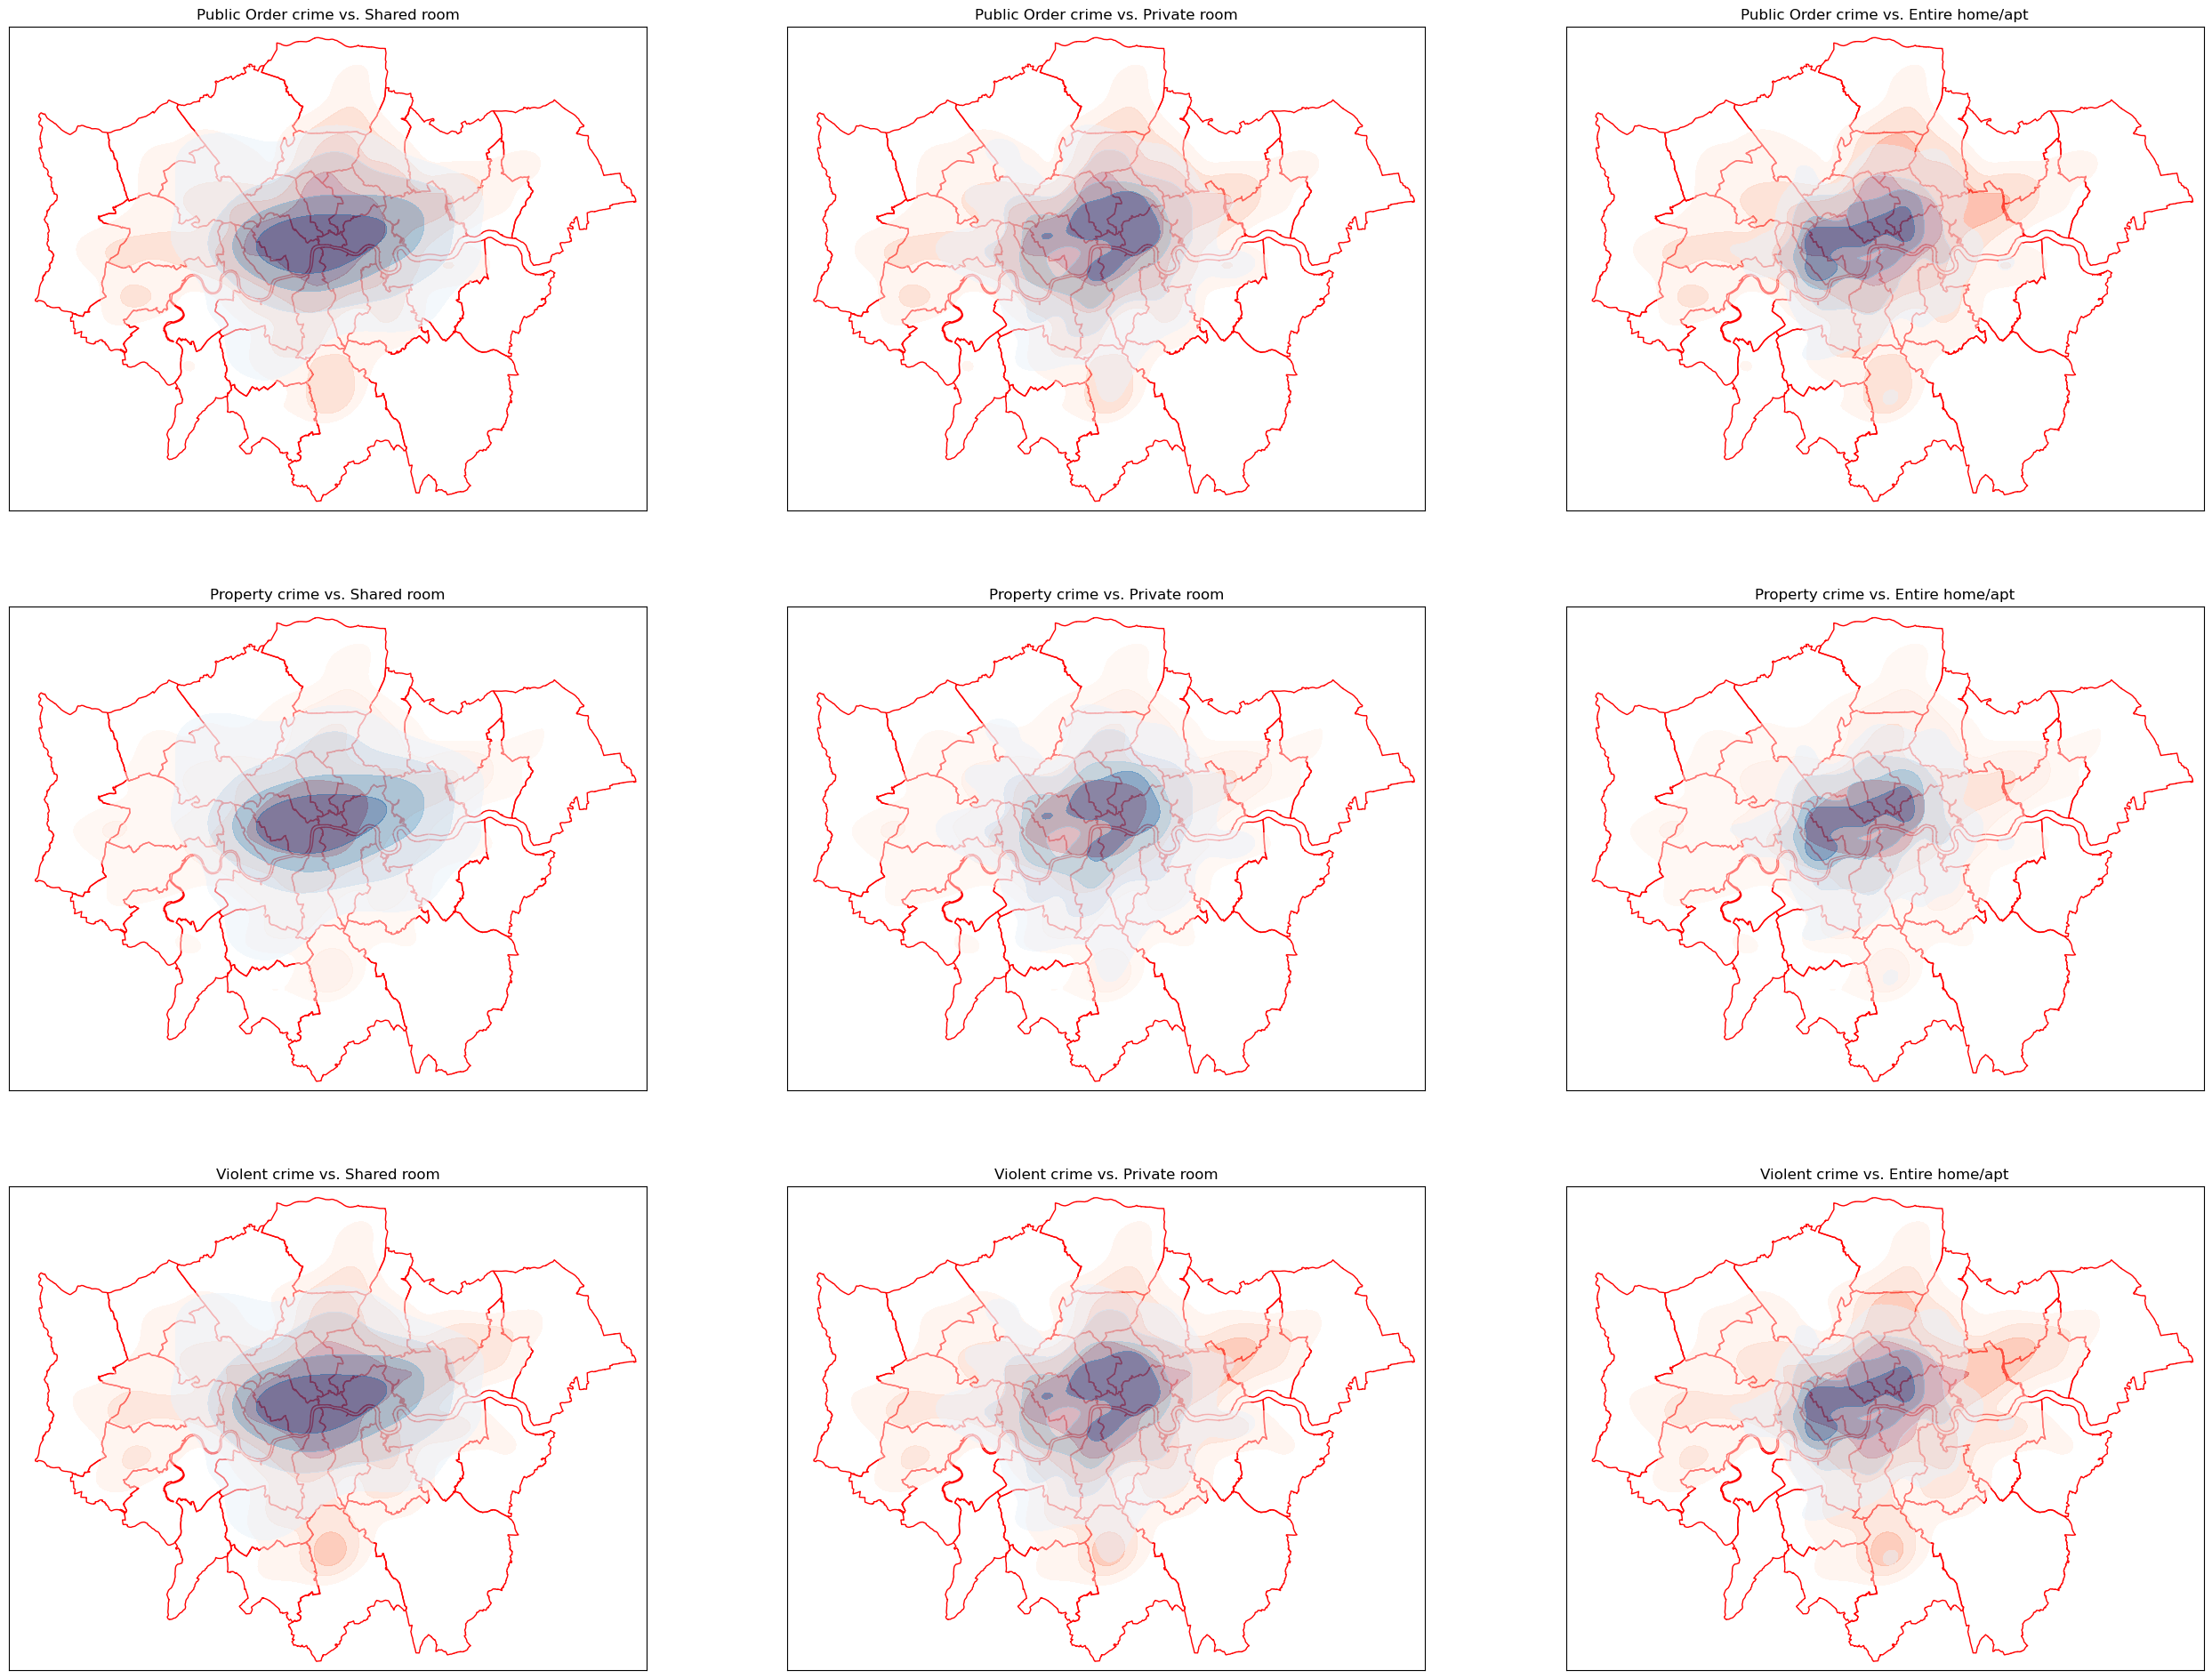

In [34]:
# KDE plot of listing types vs Crime categories
fig, axes = plt.subplots(3,3, figsize=(32,24))

# Base
for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    boros.plot(edgecolor='red', facecolor='None',ax=ax)

# KDE maps
prop_cat = ['Shared room','Private room','Entire home/apt']
crime_cat = ['Public Order crime','Property crime','Violent crime']
# Create thresholds
levels = [0.2,0.4,0.6,0.8,1]

for i in range(3):
    for j in range (3):
        sns.kdeplot(ax=axes[i,j],
                x=crime[crime['Category']==crime_cat[i]].geometry.x,
                y=crime[crime['Category']==crime_cat[i]].geometry.y,
                levels = levels, fill=True, cmap='Reds', alpha=0.5)
        sns.kdeplot(ax=axes[i,j],
                x=listings[listings.room_type==prop_cat[j]].geometry.x,
                y=listings[listings.room_type==prop_cat[j]].geometry.y,
                levels = levels, fill=True, cmap='Blues', alpha=0.5)
        axes[i,j].set_title(f'{crime_cat[i]} vs. {prop_cat[j]}')
       
plt.show()

Run correlations + spatial autocorrelation

In [35]:
lsoa_merge = lsoa

# Spatial crime and lsoa, summarise by count
sjoin_lsoa = gpd.sjoin(crime, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['crime_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa

In [36]:
# Spatial join listings and lsoa, summarise by count
sjoin_lsoa = gpd.sjoin(listings, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['listing_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa

In [37]:
# Spatial join crime by severity and lsoa, summarise by count
for s in ['Public Order crime','Property crime','Violent crime']:
    sjoin_lsoa = gpd.sjoin(crime[crime['Category']==s], lsoa_merge)
    count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
    lsoa_merge[s+'_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa_merge

# Sptial join listings by room type and lsoa, summarise by count
for r in ['Shared room','Private room','Entire home/apt']:
    sjoin_lsoa = gpd.sjoin(listings[listings['room_type']==r], lsoa_merge)
    count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
    lsoa_merge[r+'_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa_merge

In [38]:
# Change NA to 0
lsoa_merge = lsoa_merge.fillna(0)
lsoa_merge.head()

OBJECTID   LSOA21CD                   LSOA21NM  \
0         1  E01000001        City of London 001A   
1         2  E01000002        City of London 001B   
2         3  E01000003        City of London 001C   
3         4  E01000005        City of London 001E   
4         5  E01000006  Barking and Dagenham 016A   

                               GlobalID  \
0  f1865556-4e62-48e3-a025-d93a40f15e46   
1  83e78aad-ee05-44a5-a8d3-077de6ed4053   
2  69c457df-229e-4446-9577-95ac1c9be694   
3  d537d59f-237a-45ed-a514-b0ab2a93e510   
4  8d0081fe-69e2-48ac-aaf9-fd270d60e339   

                                            geometry  crime_count  \
0  POLYGON ((532105.312 182010.574, 532162.491 18...          0.0   
1  POLYGON ((532634.497 181926.016, 532619.141 18...          2.0   
2  POLYGON ((532135.138 182198.131, 532158.250 18...          1.0   
3  POLYGON ((533808.018 180767.774, 533649.037 18...         14.0   
4  POLYGON ((545122.049 184314.931, 545271.849 18...          3.0   

   listing_count  Public Order crime_count  Property crime_count  \
0           16.0                       0.0                   0.0   
1           14.0                       0.0                   1.0   
2           16.0                       0.0                   0.0   
3           99.0                       3.0                   8.0   
4            7.0                       1.0                   1.0   

   Violent crime_count  Shared room_count  Private room_count  \
0                  0.0                1.0                 5.0   
1                  1.0                0.0                 0.0   
2                  1.0                0.0                 4.0   
3                  3.0                0.0                19.0   
4                  1.0                0.0                 6.0   

   Entire home/apt_count  
0                   10.0  
1                   14.0  
2                   12.0  
3                   80.0  
4                    1.0

Text(0.5, 1.0, 'Airbnb Listing count by LSOA, Sep 2023')

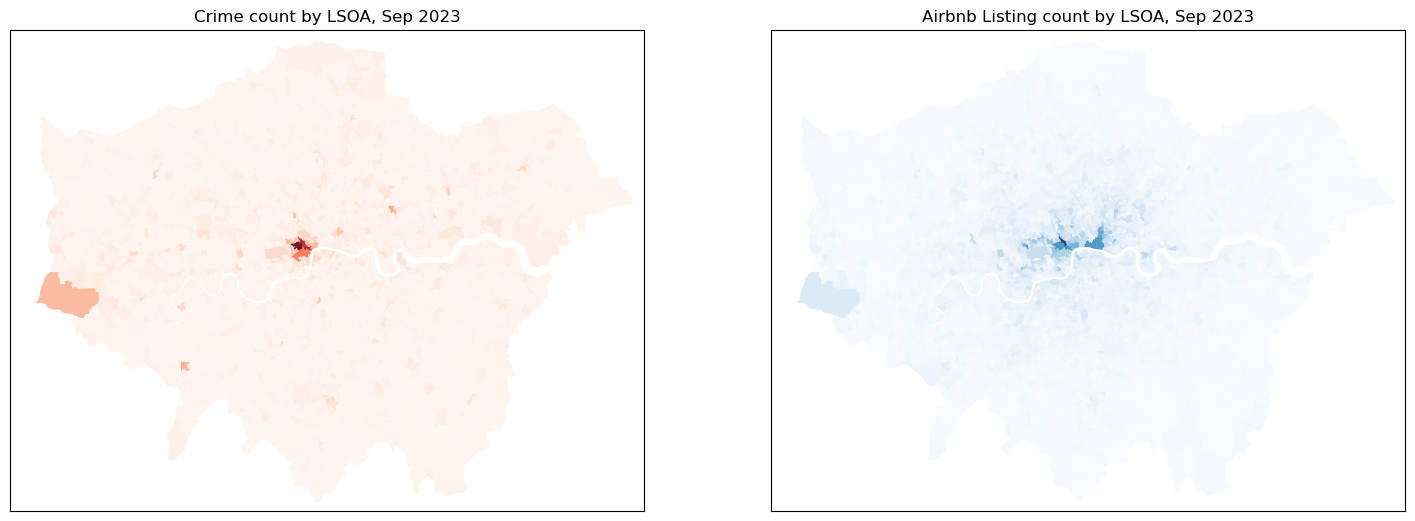

In [42]:
# Plot crime on x and listings y for lsoa_merge
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,24))
lsoa_merge.plot(ax=ax1, column='crime_count', legend=False, cmap='Reds', alpha=0.9)
lsoa_merge.plot(ax=ax2, column='listing_count', legend=False, cmap='Blues', alpha=0.9)

for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])

ax1.set_title('Crime count by LSOA, Sep 2023')
ax2.set_title('Airbnb Listing count by LSOA, Sep 2023')

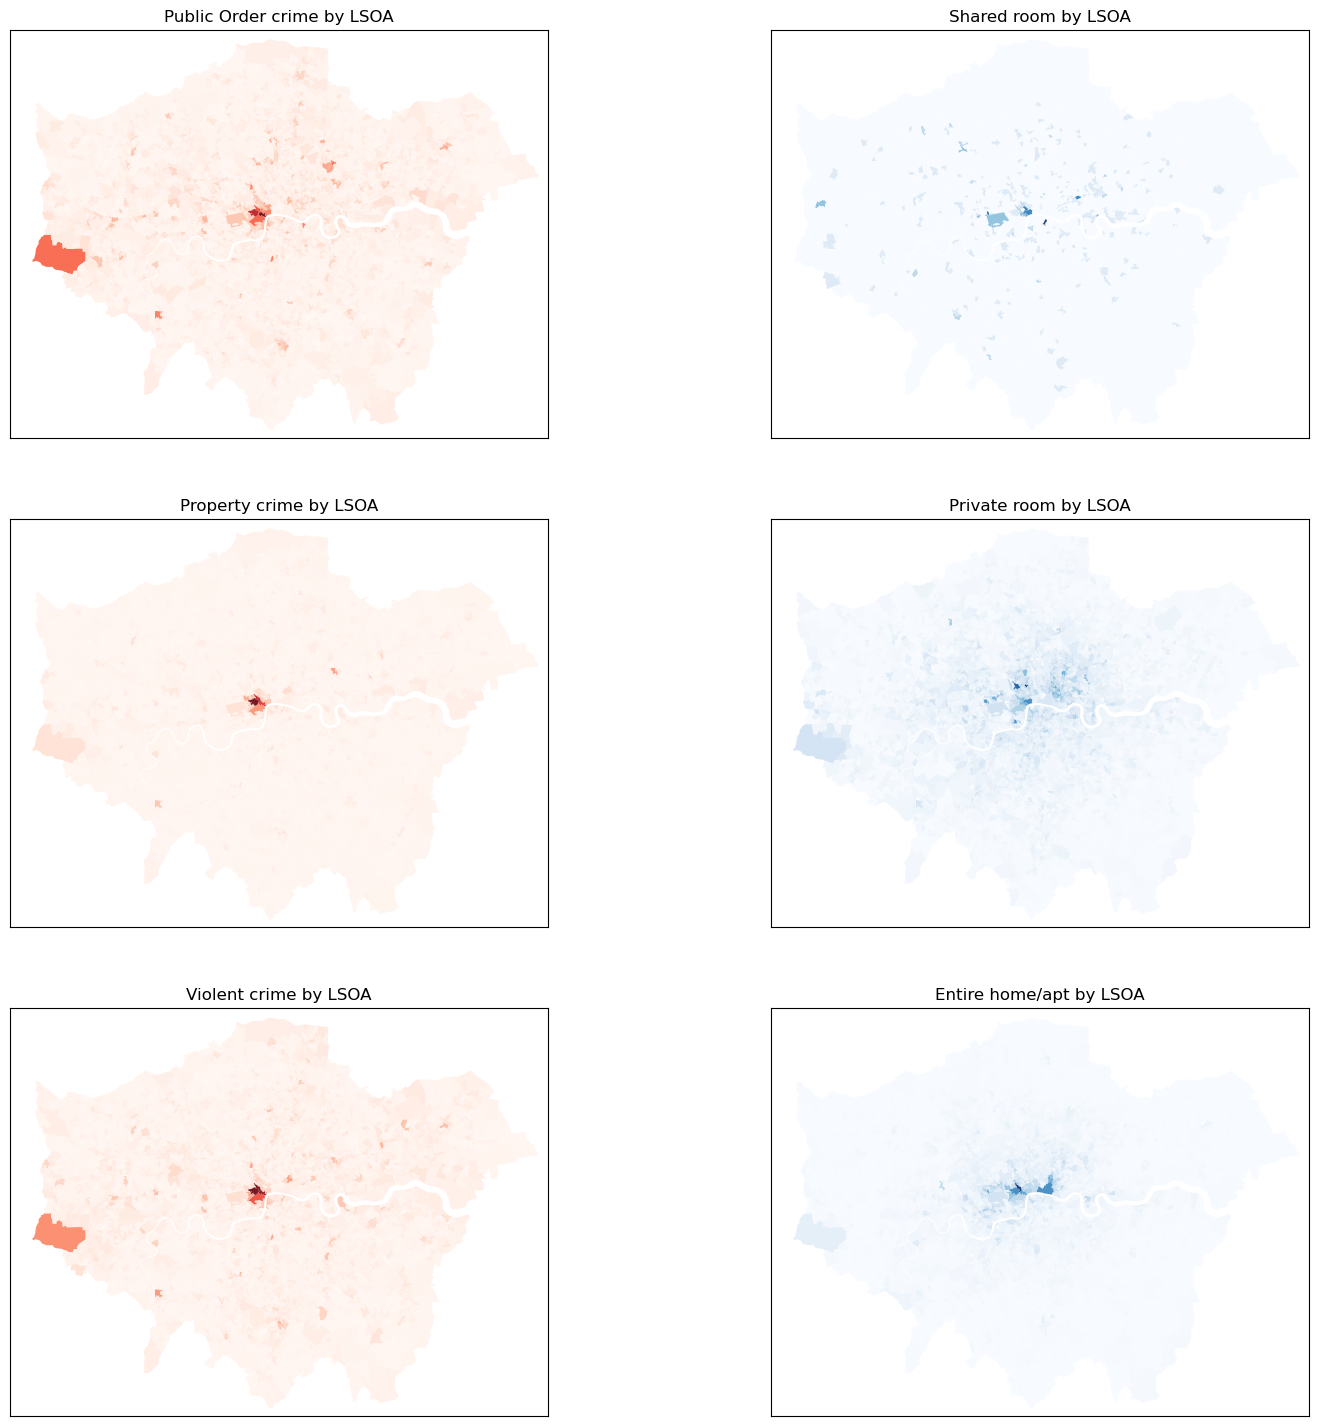

In [55]:
# Plot 3 crime types LSOA
fig, axes = plt.subplots(3,2, figsize=(18,18))

lsoa_merge.plot(ax=axes[0,0], column='Public Order crime_count', cmap='Reds', alpha=0.9)
lsoa_merge.plot(ax=axes[1,0], column='Property crime_count', cmap='Reds', alpha=0.9)
lsoa_merge.plot(ax=axes[2,0], column='Violent crime_count',  cmap='Reds', alpha=0.9)

axes[0,0].set_title('Public Order crime by LSOA')
axes[1,0].set_title('Property crime by LSOA')
axes[2,0].set_title('Violent crime by LSOA')

lsoa_merge.plot(ax=axes[0,1], column='Shared room_count',cmap='Blues', alpha=0.9)
lsoa_merge.plot(ax=axes[1,1], column='Private room_count',  cmap='Blues', alpha=0.9)
lsoa_merge.plot(ax=axes[2,1], column='Entire home/apt_count', cmap='Blues', alpha=0.9)

axes[0,1].set_title('Shared room by LSOA')
axes[1,1].set_title('Private room by LSOA')
axes[2,1].set_title('Entire home/apt by LSOA')

for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    
plt.show()

Text(0.5, -0.1, 'Correlation Matrix - Listings type vs Crime category')

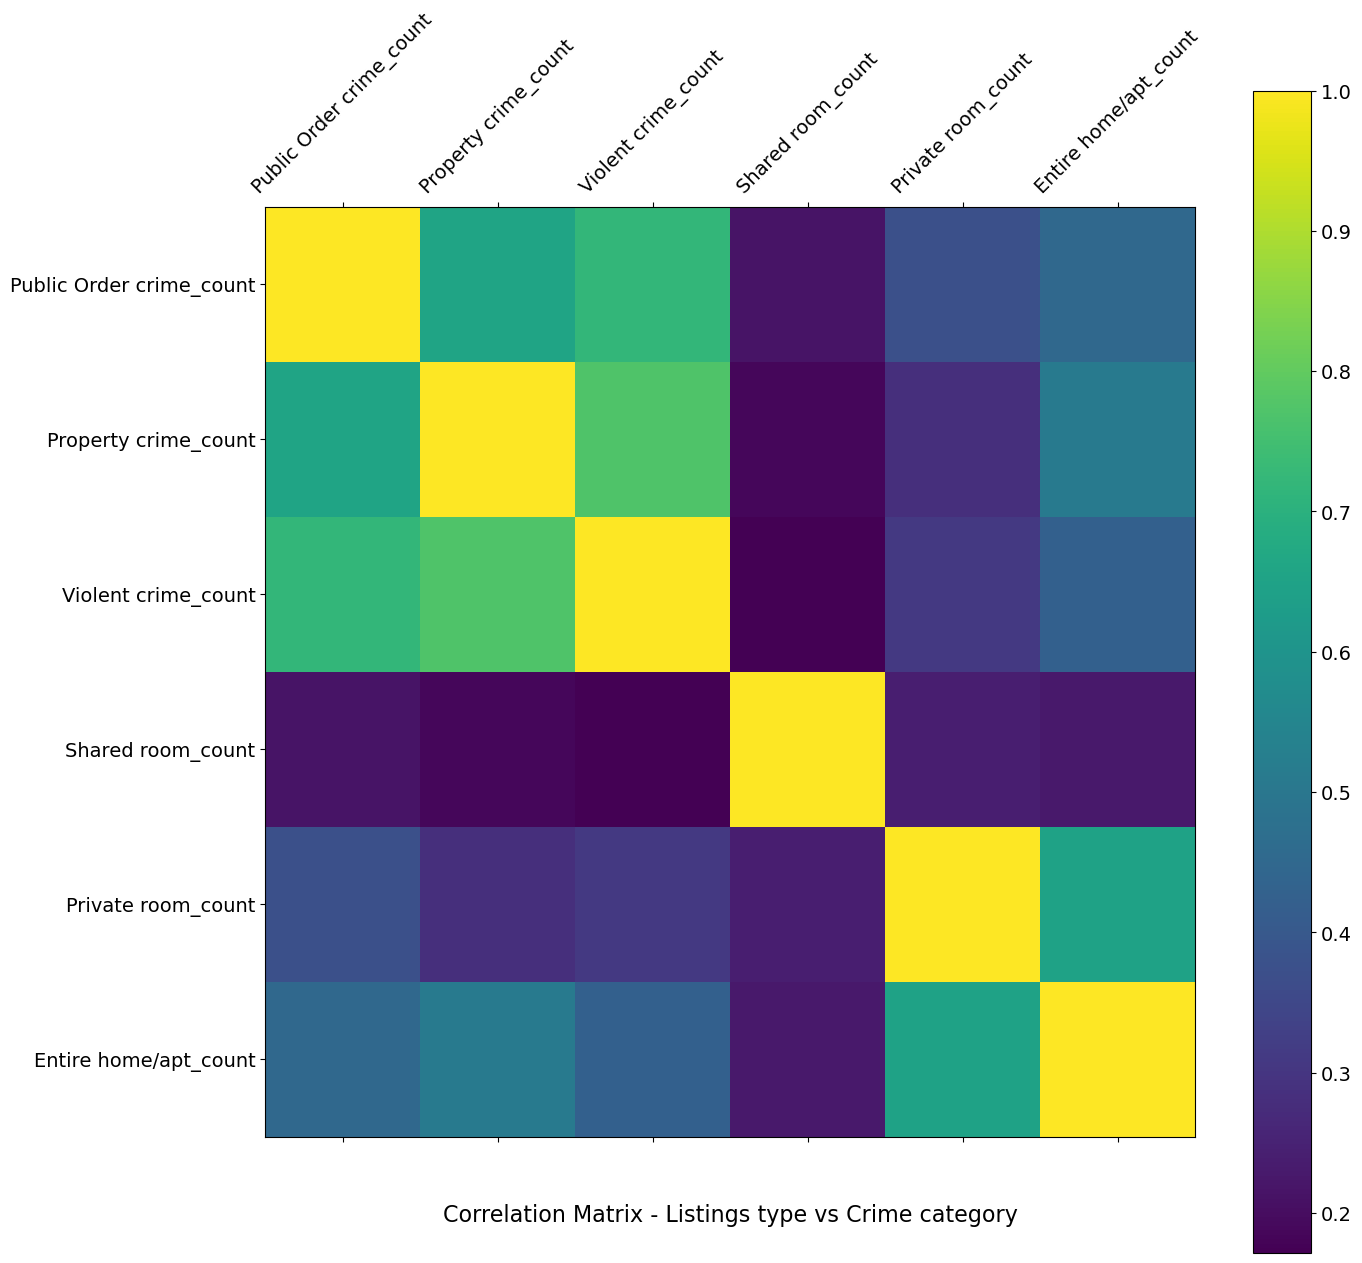

In [60]:
# Correlation matrix

# Subset last 5 columns
lsoa_merge_sub = lsoa_merge.iloc[:,-6:]

f = plt.figure(figsize=(15, 15)) # creates a new figure, sets length and width

plt.matshow(lsoa_merge_sub.corr(numeric_only=True), fignum=f.number) # matshow - creates matrix plot
plt.xticks(range(lsoa_merge_sub.select_dtypes(['number']).shape[1]), lsoa_merge_sub.select_dtypes(['number']).columns, fontsize=14, rotation=45) # add the x axis label
plt.yticks(range(lsoa_merge_sub.select_dtypes(['number']).shape[1]), lsoa_merge_sub.select_dtypes(['number']).columns, fontsize=14) # add the y axis label

# select_dtypes(['number']) - choose the numeric variables
cb = plt.colorbar() # add a legend to the right hand (default position)
cb.ax.tick_params(labelsize=14) # label size
plt.title( 'Correlation Matrix - Listings type vs Crime category', fontsize=16,y=-0.1)


Entire home/apt has the highest correl to Crime (relevant to tourism), followed by Private room and Shared room

Identifying locations to zoom into with a bivariate I guess

### Inferring statistics (Question #7 - 45 points)

*Objective:* 
Show causation and infer recommendations

1. Step 1
2. Step 2
3. Step 3

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText  # for adding some text

In [72]:
lsoa_stat.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 235 columns):
 #    Column                                                                           Dtype 
---   ------                                                                           ----- 
 0    LSOA code                                                                        object
 1    local authority code                                                             object
 2    local authority name                                                             object
 3    All households                                                                   int64 
 4    Detached                                                                         int64 
 5    Semi-detached                                                                    int64 
 6    Terraced                                                                         int64 
 7    Purpose built flat                      

Chosen columns:
X
- Population density: Usual resident (11) / Area (need to get)
- Bad+Very Bad Health (120+121) / Pop (11)
- deprived 2+ dimension (144+145+146) / Pop (11)
- Unemployed (72) / Pop (11)
- Young people (17+18+19) / Pop (11)
- 3x Airbnb listings (3 types) / Household number (3)
Y
- Crime-relevant / Pop (11)

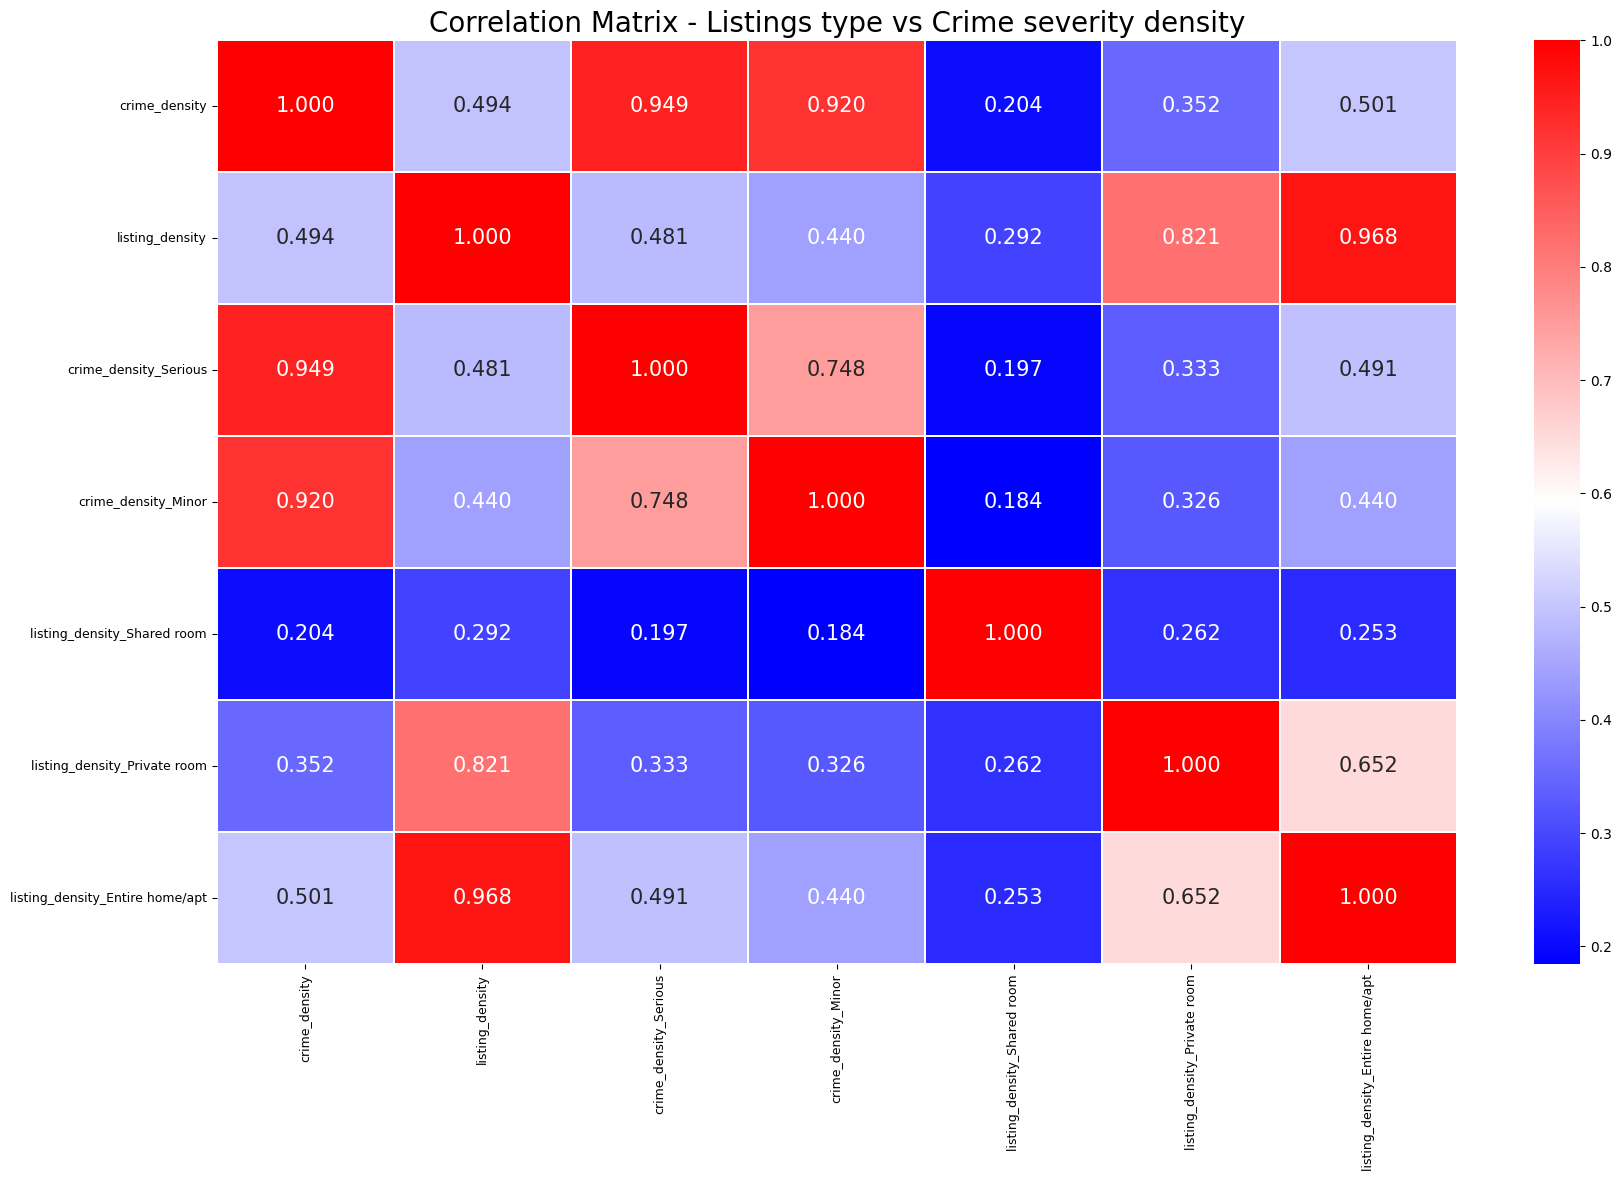

In [83]:
# make the correlation matrix
lsoa_merge1_sub2 = lsoa_merge1.iloc[:,-7:]
lsoa_merge1_sub_comatrix = lsoa_merge1_sub2.corr()
### plot the correlation matrix plot
# cor = df_cormatrix.sort_values(by='fires', ascending=False)
fig, axes = plt.subplots(figsize = (20,12))
sns.heatmap(lsoa_merge1_sub_comatrix, cmap ='bwr', annot = True, fmt='.3f', linewidths = 0.1, annot_kws = {'size': 15}, ax = axes)
axes.tick_params(labelsize = 9)
axes.set_title('Correlation Matrix - Listings type vs Crime severity density', fontsize = 20)
plt.show()

 Avoid multicollinear

In [53]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [55]:
lsoa_merge2 = lsoa_merge1.loc[:,['crime_density','listing_density_Shared room', 'listing_density_Private room', 'listing_density_Entire home/apt']]
lsoa_merge1_VIF = drop_column_using_vif_(lsoa_merge1.drop('crime_density',axis=1))
print("The columns remaining after VIF selection are:")
print(lsoa_merge1_VIF.columns)
lsoa_merge1_VIF.head()

The columns remaining after VIF selection are:
Index(['listing_density_Shared room', 'listing_density_Private room',
       'listing_density_Entire home/apt'],
      dtype='object')


listing_density_Shared room  listing_density_Private room  \
0                     0.000679                      0.003394   
1                     0.000000                      0.000000   
2                     0.000000                      0.002480   
3                     0.000000                      0.018002   
4                     0.000000                      0.003261   

   listing_density_Entire home/apt  
0                         0.006789  
1                         0.010130  
2                         0.007440  
3                         0.071107  
4                         0.000543

# OSL

In [87]:
import statsmodels.api as sm
model = sm.OLS(endog=lsoa_merge1[['crime_density']], exog=sm.add_constant(lsoa_merge1_VIF)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          crime_density   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     577.2
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          4.50e-322
Time:                        17:18:20   Log-Likelihood:                 15492.
No. Observations:                4994   AIC:                        -3.098e+04
Df Residuals:                    4990   BIC:                        -3.095e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0054      0.000     26.823      0.000       0.005       0.006
listing_density_Shared room         4.6813      0.749      6.247      0.000       3.212       6.150
listing_density_Private room        0.0926      0.048      1.944      0.052      -0.001       0.186
listing_density_Entire home/apt     0.5902      0.021     28.407      0.000       0.549       0.631
==============================================================================
Omnibus:                     7699.951   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7588886.765
Skew:                           9.367   Prob(JB):                         0.00
Kurtosis:                     193.051   Cond. No.                     4.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residual analysis

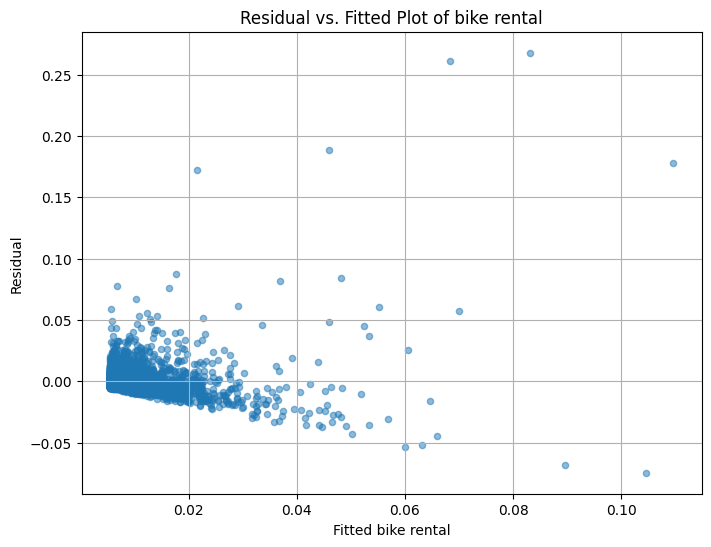

In [89]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model.fittedvalues, model.resid, alpha = 0.5, s=20)
# plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted bike rental')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of bike rental')
# Adding grid lines
plt.grid(True)
plt.show()

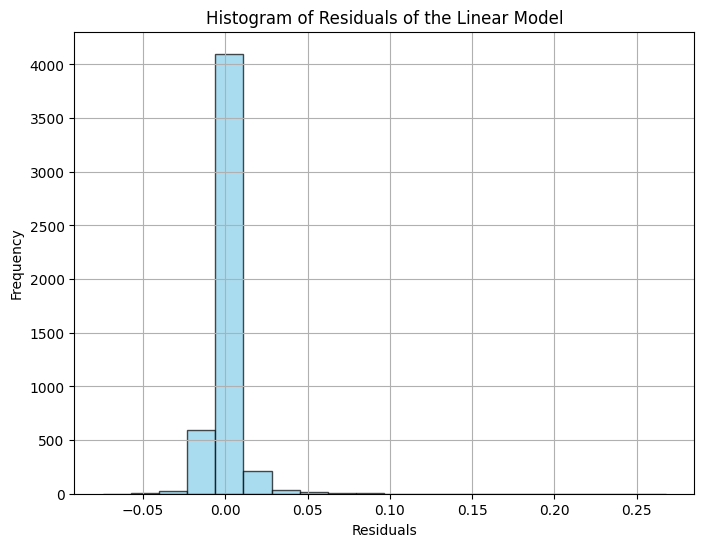

In [90]:
# Histogram of residuals

# Set the figure size
plt.figure(figsize=(8, 6))  

# Plotting the histogram
plt.hist(model.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Linear Model')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

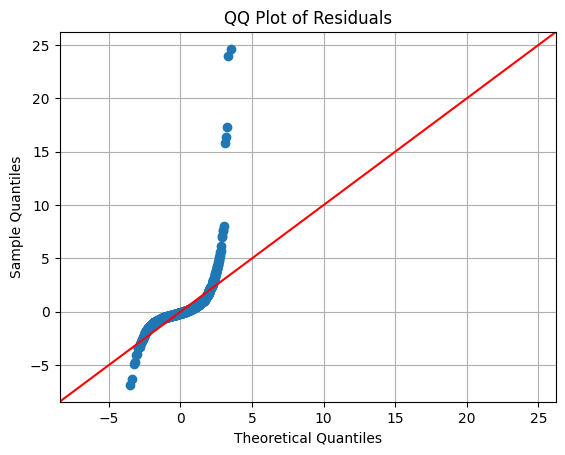

In [91]:
# (optional) the QQ plot of residuals
# More details: https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html
fig = sm.qqplot(model.resid, fit=True, line="45")
plt.title('QQ Plot of Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

## Discussion of the four conditions 

- Linear relationship

The points in the residual plot do not bounce randomly around the x axis (residual=0). Therefore, it looks like ther is no linear relationship between the variables.

- Independent errors

The points in the residual plot are not randomly distributed and some clusters/patterns can be seens. Therefore, it is unlikely that the errors are independently distributed.

- Normally distributed errors

The histogram is asymmetric ans shows a positive skew, with more data points clustered to the right of residual=0.

The QQ plot shows that the residuals deviates from the theoretical quantiles when the residual value is very small or large.

Therefore, it is not likely that the residuals are normally distributed.

- Equal variance

The points do not form a horizontal band around residual=0, and the range of residuals increases with the fitted y value. Therefore, it is unlikely that the residuals have equal variance.


## Statistical tests of the four conditions

### Linear relationship

In [93]:
import statsmodels
test_fires = statsmodels.stats.diagnostic.linear_rainbow(model)
# This function returns a tuple consisting of two values: the test statistic based on the F test and the pvalue of the test
# Note that these two values are not named. Therefore, you need to know the order before accessing these two values.
print("The p value of the fires test: {:.4f}".format(test_fires[1]))

The p value of the fires test: 0.0000


As the p value is less than 0.05, we will reject the null hypothesis. This dataset and model does not meet the linear relationship condition.

### Independent errors

We will use the Durbin-Watson test and and Ljung-Box test for testing the independent errors. 

This test assumes that there is no serial correlation in the residuals. 

This statistic will always be between 0 and 4. 

If there is no serial correlation, the test statistic equals 2. 

The closer to 0, the more evidence for positive serial correlation. 

The closer to 4, the more evidence for negative serial correlation. 

Empirically, if the test statistic is between 1 and 2, it is likely that there is no serial correlation in the residuals.

In [94]:
test_dw = statsmodels.stats.stattools.durbin_watson(model.resid)
print("Durbin-Watson test statistic is: {:.4f}".format(test_dw))

Durbin-Watson test statistic is: 1.6682


demonstrates that there might be serial correlation in this model and the residuals are not independently distributed.

### Normally distributed errors

We will use the Jarque-Bera test for testing the normality of residuals. 

The null hypothesis of this test is that the data is normally distributed.


In [95]:
test_JB = statsmodels.stats.stattools.jarque_bera(model.resid)
print("The p value of the Jarque Bera test: {:.4f}".format(test_JB[1]))

The p value of the Jarque Bera test: 0.0000


As the p value is less than 0.05, we will reject the null hypothesis and conclude that the residuals are not normally distributed.

# The Spatial Lag model

Moran’s I shows spatial autocorrelation

In [102]:
import pandas as pd
from libpysal.cg import KDTree, RADIUS_EARTH_MILES
from libpysal.weights import KNN
from spreg import ML_Lag

X = lsoa_merge1[['listing_density_Shared room', 'listing_density_Private room', 'listing_density_Entire home/apt']].to_numpy()
y = lsoa_merge1['crime_density'].to_numpy()
# Extract the centroids of the polygons
centroids = lsoa_merge1['geometry'].centroid

# Create a KDTree using the centroids
tree = KDTree(data=list(zip(centroids.x, centroids.y)),
              distance_metric='arc', radius=RADIUS_EARTH_MILES)

# Create a KNN weights matrix
nn = KNN(tree, k=5)



mod = ML_Lag(
    y=y,
    x=X,
    w=nn,
    name_y='crime_density',
    name_x=['listing_density_Shared room', 'listing_density_Private room', 'listing_density_Entire home/apt']
)

# results


print(mod.summary)

c:\Users\17197\AppData\Local\Programs\Python\Python311\Lib\site-packages\spreg\ml_lag.py:634: RuntimeWarning: divide by zero encountered in log
  jacob = np.log(np.linalg.det(a))
c:\Users\17197\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:2306: RuntimeWarning: invalid value encountered in multiply
  q = (xf - fulc) * (fx - fnfc)
c:\Users\17197\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:2307: RuntimeWarning: invalid value encountered in subtract
  p = (xf - fulc) * q - (xf - nfc) * r


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :crime_density                Number of Observations:        4994
Mean dependent var  :      0.0094                Number of Variables   :           5
S.D. dependent var  :      0.0126                Degrees of Freedom    :        4989
Pseudo R-squared    :      0.2578
Spatial Pseudo R-squared:  0.2577
Log likelihood      :  15492.4157
Sigma-square ML     :      0.0001                Akaike info criterion :  -30974.831
S.E of regression   :      0.0109                Schwarz criterion     :  -30942.252

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------------------------------

In [ ]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet','City of London']:
    mapping[b]='Outer West and North West'
print(len(mapping.keys()))